# Linearly decoded VAE

This notebook shows how to use the 'linearly decoded VAE' model which explicitly links latent variables of cells to genes.

The scVI package learns low-dimensional latent representations of cells which get mapped to parameters of probability distributions which can generate counts consistent to what is observed from data. In the standard `VAE` model of scVI these parameters for each gene and cell arise from applying neural networks to the latent variables. Neural networks are flexible and can represent non-linearities in the data. This comes at a price, there is no direct link between a latent variable dimension and any potential set of genes which would covary across it.

The `LDVAE` model replaces the neural networks with linear functions. Now a higher value along a latent dimension will directly correspond to higher expression of the genes with high weights assigned to that dimension.

This leads to a generative model comparable to probabilistic PCA or factor analysis, but generates counts rather than real numbers. Using the framework of scVI also allows variational inference which scales to very large datasets and can make use of GPUs for additional speed.

This notebook demonstrates how to fit an `LDVAE` model to scRNA-seq data, plot the latent variables, and interpret which genes are linked to latent variables.

As an example, we use the PBMC 3K from 10x Genomics. This data is also used in the [Seurat tutorial for PCA](https://satijalab.org/seurat/v3.0/pbmc3k_tutorial.html), and we can compare the results here with those results.

In [1]:
# Cell left blank for testing purposes

# Automated testing configuration

In [2]:
import os 

def allow_notebook_for_test():
    print("Testing the ldvae notebook")


test_mode = False
save_path = "data/"
n_epochs_all = None
show_plot = True


if not test_mode:
    save_path = "../../data"
    
data_path = os.path.join(save_path, "filtered_gene_bc_matrices/hg19/")

In [3]:
import torch

from scvi.dataset import GeneExpressionDataset, Dataset10X
from scvi.models import LDVAE
from scvi.inference import UnsupervisedTrainer, Trainer
from scvi.inference.posterior import Posterior

import pandas as pd
import anndata
import scanpy as sc

import matplotlib.pyplot as plt

if not test_mode:
    %matplotlib inline

[2019-10-19 18:17:02,439] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.
/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/scikit_learn-0.19.2-py3.7-linux-x86_64.egg/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Initialization

In [4]:
import torch
import numpy as np

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [5]:
cells_dataset = Dataset10X(
    save_path = save_path + "/10X/pbmc_10k_protein_v3/",
    measurement_names_column=1,
    dense=True,
)

[2019-10-19 18:17:07,579] INFO - scvi.dataset.dataset10X | Preprocessing dataset
[2019-10-19 18:17:42,350] INFO - scvi.dataset.dataset10X | Finished preprocessing dataset
[2019-10-19 18:17:44,285] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-10-19 18:17:44,287] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-10-19 18:17:44,704] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-10-19 18:17:45,119] INFO - scvi.dataset.dataset | Downsampled from 7865 to 7865 cells


# Create and fit `LDVAE` model

First subsample 1,000 genes from the original data.

Then we initialize an `LDVAE` model and a `Trainer` for that model. Here we set the latent space to have 10 dimensions.

In [6]:
cells_dataset.subsample_genes(1000)

[2019-10-19 18:17:49,225] INFO - scvi.dataset.dataset | Downsampling from 33538 to 1000 genes
[2019-10-19 18:17:49,314] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-10-19 18:17:49,342] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2019-10-19 18:17:49,371] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-10-19 18:17:49,387] INFO - scvi.dataset.dataset | Downsampled from 7865 to 7865 cells


In [7]:
vae = LDVAE(
    cells_dataset.nb_genes,
    n_batch=cells_dataset.n_batches,
    n_latent=10,
    n_layers_encoder=1,
    n_hidden=128,
    reconstruction_loss="nb",
    latent_distribution="normal",
)

In [8]:
trainer = UnsupervisedTrainer(vae,
                              cells_dataset,
                              frequency=1,
                              use_cuda=True,
                              n_epochs_kl_warmup=None
                             )

Now train the model using the trainer, and inspect the convergence.

In [9]:
n_epochs = 250 if n_epochs_all is None else n_epochs_all
trainer.train(lr=5e-3, n_epochs=250)

training: 100%|██████████| 250/250 [03:00<00:00,  1.39it/s]


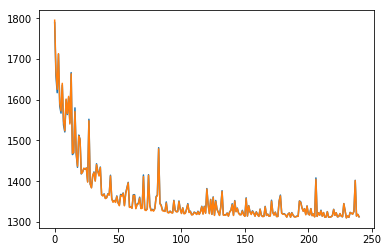

In [10]:
if not test_mode:
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(trainer.history['elbo_train_set'][10:])
    ax.plot(trainer.history['elbo_test_set'][10:])

# Extract and plot latent dimensions for cells

From the fitted model we extract the (mean) values for the latent dimensions. We store the values in the AnnData object for convenience.

In [11]:
full = trainer.create_posterior(trainer.model, cells_dataset, indices=np.arange(len(cells_dataset)))
Z_hat = full.sequential().get_latent()[0]
adata = anndata.AnnData(cells_dataset.X)

In [12]:
for i, z in enumerate(Z_hat.T):
    adata.obs[f'Z_{i}'] = z

Now we can plot the latent dimension coordinates for each cell. A quick (albeit not complete) way to view these is to make a series of 2D scatter plots that cover all the dimensions. Since we are representing the cells by 10 dimensions, this leads to 5 scatter plots.

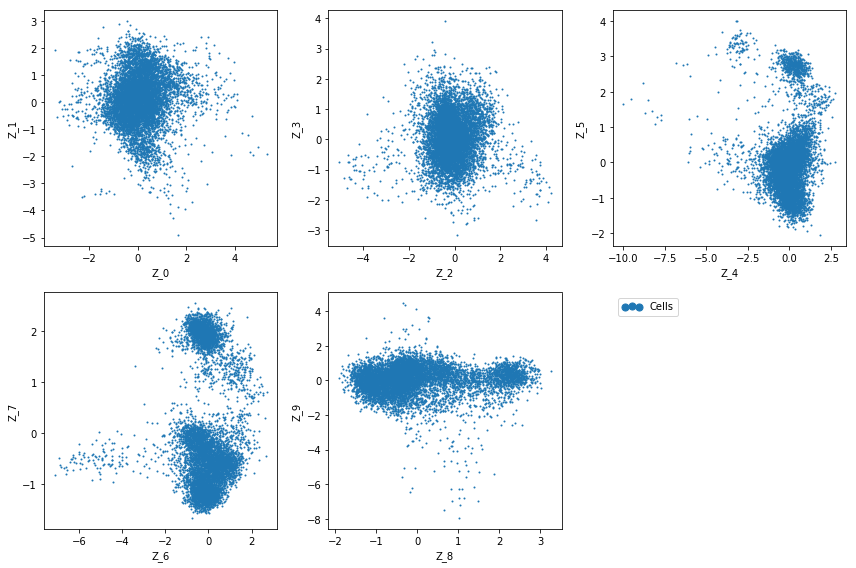

In [13]:
fig = plt.figure(figsize=(12, 8))

for f in range(0, 9, 2):
    plt.subplot(2, 3, int(f / 2) + 1)

    plt.scatter(adata.obs[f'Z_{f}'], adata.obs[f'Z_{f + 1}'], marker='.', s=4, label='Cells')

    plt.xlabel(f'Z_{f}')
    plt.ylabel(f'Z_{f + 1}')

plt.subplot(2, 3, 6)    
plt.scatter(adata.obs[f'Z_{f}'], adata.obs[f'Z_{f + 1}'], marker='.', label='Cells', s=4)
plt.scatter(adata.obs[f'Z_{f}'], adata.obs[f'Z_{f + 1}'], c='w', label=None)
plt.gca().set_frame_on(False)
plt.gca().axis('off')

lgd = plt.legend(scatterpoints=3, loc='upper left')
for handle in lgd.legendHandles:
    handle.set_sizes([200])


plt.tight_layout()

The question now is how does the latent dimensions link to genes?

For a given cell x, the expression of the gene g is proportional to x_g = w_(1, g) * z_1 + ... + w_(10, g) * z_10. Moving from low values to high values in z_1 will mostly affect expression of genes with large w_(1, :) weights. We can extract these weights from the `LDVAE` model, and identify which genes have high weights for each latent dimension.

In [14]:
loadings = vae.get_loadings()
loadings = \
pd.DataFrame.from_records(loadings, index=cells_dataset.gene_names,
                                    columns=[f'Z_{i}' for i in range(10)])

In [15]:
loadings.head()

,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9
IGKC,-1.028898,-1.259035,-1.336126,-1.114149,-1.344655,-0.432339,-1.283991,-1.523566,-1.500641,-1.036441
IGHA1,-2.050399,-1.961106,-2.376477,-1.987052,-2.566273,-1.747569,-2.416620,-2.390869,-2.245493,-1.929727
IGLC2,-2.708226,-3.224808,-3.601567,-3.266905,-3.332240,-1.930490,-3.053496,-3.582881,-3.405784,-3.221071
IGLC3,-3.720896,-3.892133,-4.217211,-3.800789,-3.785022,-2.614218,-3.661552,-4.174701,-4.049794,-3.889431
IGHM,-2.740372,-3.549460,-3.342474,-3.004852,-3.258056,-1.866528,-2.961346,-3.579795,-3.543764,-3.238506


For every latent variable Z, we extract the genes with largest _magnitude_, and separate genes with large negative values from genes with large positive values. We print out the top 5 genes in each direction for each latent variable.

In [16]:
print('Top loadings by magnitude\n---------------------')
for clmn_ in loadings:
    loading_ = loadings[clmn_].sort_values()
    fstr = clmn_ + ':\t'
    fstr += '\t'.join([f'{i}, {loading_[i]:.2}' for i in loading_.head(5).index])
    fstr += '\n\t...\n\t'
    fstr += '\t'.join([f'{i}, {loading_[i]:.2}' for i in loading_.tail(5).index])
    print(fstr + '\n---------------------\n')

Top loadings by magnitude
---------------------
Z_0:	C1QA, -8.2	LYPD2, -8.2	C1QB, -7.9	UBE2C, -7.4	CLEC10A, -7.0
	...
	MT-CO2, 2.7	EEF1A1, 2.8	MT-CO1, 2.9	B2M, 3.0	MALAT1, 4.0
---------------------

Z_1:	HBB, -8.2	LYPD2, -7.6	UBE2C, -7.5	IGLC7, -7.3	C1QA, -7.1
	...
	MT-CO2, 2.9	MT-CO1, 3.0	EEF1A1, 3.0	B2M, 3.2	MALAT1, 3.9
---------------------

Z_2:	UBE2C, -7.9	IGLC7, -7.3	FCER1A, -7.2	CLEC10A, -6.9	C1QA, -6.9
	...
	EEF1A1, 2.9	MT-CO2, 2.9	MT-CO1, 3.0	B2M, 3.1	MALAT1, 4.0
---------------------

Z_3:	UBE2C, -8.2	C1QA, -7.7	LYPD2, -7.6	CLEC10A, -7.4	C1QB, -7.3
	...
	EEF1A1, 2.8	MT-CO2, 2.8	MT-CO1, 3.0	B2M, 3.1	MALAT1, 4.0
---------------------

Z_4:	UBE2C, -7.7	LYPD2, -7.2	IGLC7, -7.1	HBB, -6.9	RRM2, -6.8
	...
	TMSB4X, 2.7	MT-CO1, 2.7	EEF1A1, 2.9	B2M, 3.1	MALAT1, 3.9
---------------------

Z_5:	LYPD2, -7.9	UBE2C, -7.7	HBB, -7.5	C1QA, -7.1	C1QB, -6.8
	...
	EEF1A1, 2.7	MT-CO2, 2.8	MT-CO1, 2.9	B2M, 2.9	MALAT1, 3.8
---------------------

Z_6:	UBE2C, -8.2	PCLAF, -7.2	HBB, -7.2	RRM2, -7.1	LYPD

It is important to keep in mind that unlike traditional PCA, these latent variables are not ordered. Z_0 does not necessarily explain more variance than Z_1.

These top genes can be interpreted as following most of the structural variation in the data.

The `LDVAE` model further supports the same scVI functionality as the `VAE` model, so all posterior methods work the same. Here we show how to use scanpy to visualize the latent space.

In [17]:
adata.obsm["X_scVI"] = Z_hat
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=20)
sc.tl.umap(adata, min_dist=0.1)
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.8)

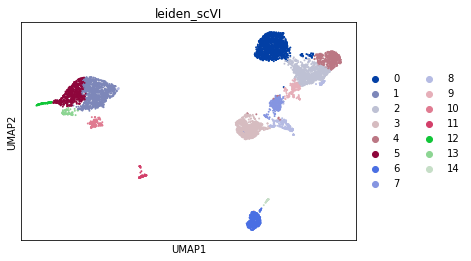

In [18]:
sc.pl.umap(adata, color=["leiden_scVI"], show=show_plot)

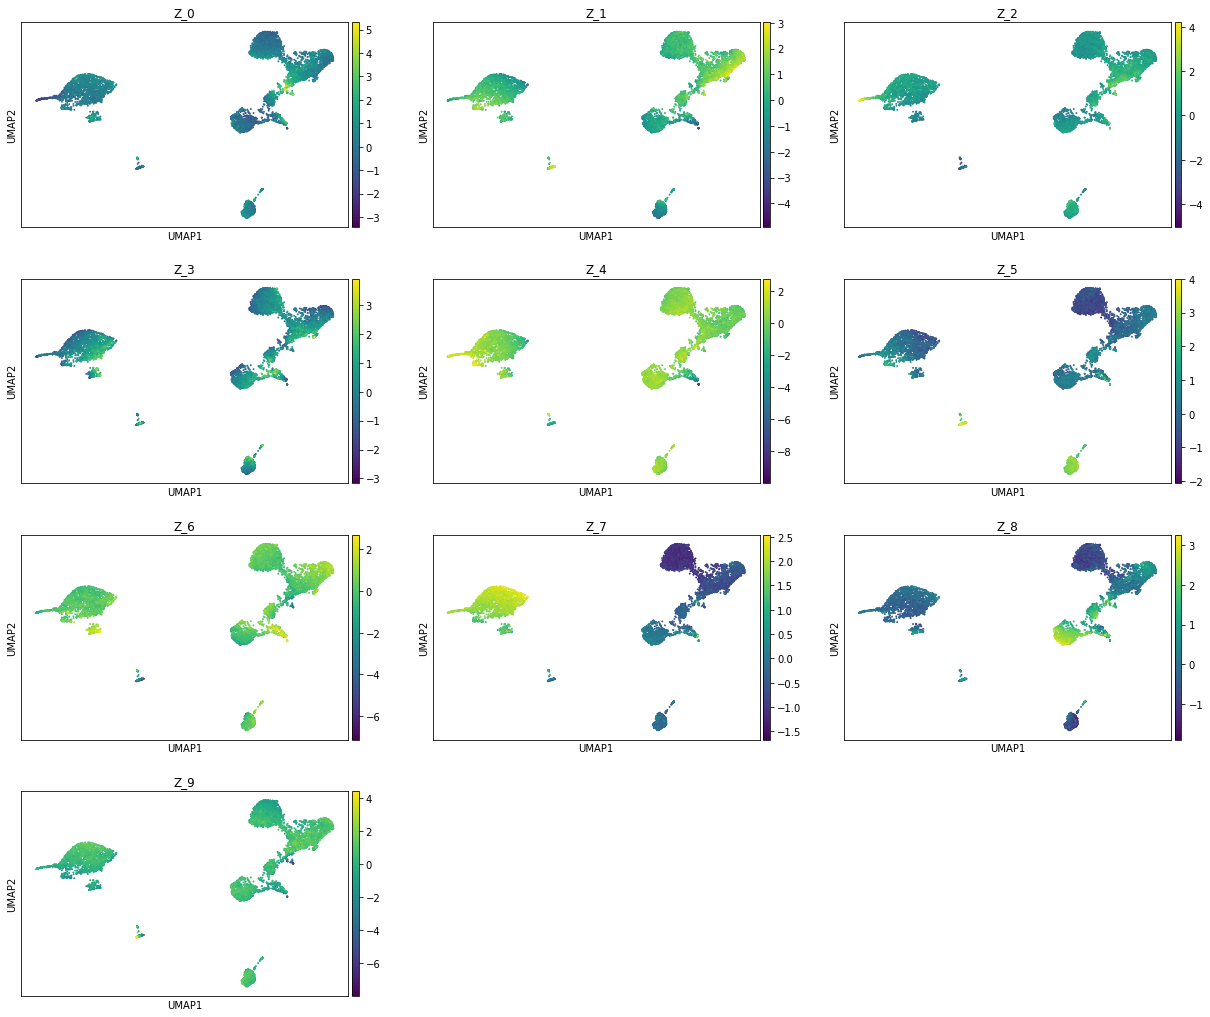

In [20]:
zs = [f'Z_{i}' for i in range(vae.n_latent)]
sc.pl.umap(adata, color=zs, show=show_plot, ncols=3)